<a href="https://colab.research.google.com/github/ryanharvey1/teamA-grebes-NMA2020/blob/master/speed_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find running calcium response correlations

This script finds significant linear relationships between calcium response and running speed

In [51]:
import matplotlib.pyplot as plt
import sys

download data

TODO: make general for wider dataset

In [1]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())        

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


get correlation

In [44]:
def compute_speed_mod(speed,fr):

  # get speed score
  speed_score = np.corrcoef(speed,fr)[0,1]

  return speed_score

get shuffled pvalue

Each cell’s response vector was shuffled by a random interval from ~20 s before or after its true position


In [64]:
def shuffle_speed_mod(speed_score,speed,fr,shuffn=1000):

  a = -20;
  b = 20; 
  r = np.random.randint(a,b,shuffn)

  speed_score_shuff = []
  for i in range(len(r)):
    sc = compute_speed_mod(speed,np.roll(fr,r[i]))
    speed_score_shuff.append(sc)
 
  # DOI: 10.2202/1544-6115.1585
  shuff_pvalue = (sum(np.abs(speed_score_shuff) > np.abs(speed_score)) + 1) /(len(speed_score_shuff) + 1);

  return shuff_pvalue

run though every cell

In [ ]:
cells,time = dat['sresp'].shape

speed_score = []
shuff_pvalue = []
for i in range(cells):
  r = compute_speed_mod(np.squeeze(dat['run']),dat['sresp'][i,:])
  speed_score.append(r)
  shuff_pvalue.append(shuffle_speed_mod(r,np.squeeze(dat['run']),dat['sresp'][i,:]))
  sys.stdout.write('\rcurrent cell: %d' %i)
  sys.stdout.flush()

If data was already ran, load it here

In [66]:
# np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_score.npy',speed_score)
# np.save('/content/drive/My Drive/nma_data/6163622_v6/shuff_pvalue.npy',shuff_pvalue)

speed_score = np.load('/content/drive/My Drive/nma_data/6163622_v6/speed_score.npy')
shuff_pvalue = np.load('/content/drive/My Drive/nma_data/6163622_v6/shuff_pvalue.npy')

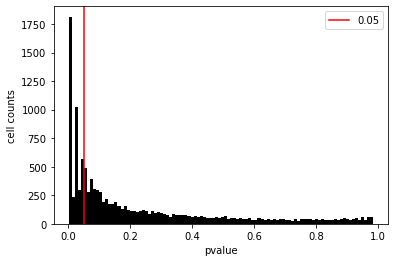

3939  of  11983  cells are modulated by running speed


In [77]:
plt.figure()
plt.hist(shuff_pvalue,100,color='k')
plt.axvline(0.05,color = 'r',label='0.05')
plt.xlabel('pvalue')
plt.ylabel('cell counts')
plt.legend()
plt.show()

print(sum(shuff_pvalue < 0.05),' of ',cells,' cells are modulated by running speed')